In [1]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn

from modules import EDMPrecond
from diffusion import EdmSampler

In [2]:
def load_models(model_path="models/edm_e300_bs16/ema_ckpt.pt",
                device="cuda:1",
                noise_steps=30,
                settings_dim=13):
    """
    Load and return the EDM model, sampler.
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # Load EDM Model
    model = EDMPrecond(device=device).to(device)
    ckpt = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(ckpt)

    # Load Sampler
    sampler = EdmSampler(net=model, num_steps=noise_steps)

    model.eval()

    return model, sampler


def edm_sampler(model, 
                sampler, 
                optimized_indices, 
                fixed_indices, 
                target_cond_vector, 
                settings_dim=13, 
                cfg_scale=3):
    """
    Uses a preloaded model, and sampler to generate a spectrum.
    This version handles non-contiguous optimized and fixed parameters using indices.
    """
    device = next(model.parameters()).device

    # Create a full conditional vector (initialize with zeros or some default value)
    full_conditional_vector = torch.zeros(len(target_cond_vector), dtype=torch.float32).to(device)

    # Insert the fixed parameters into the appropriate positions in the full vector
    full_conditional_vector[fixed_indices] = torch.tensor(target_cond_vector[fixed_indices], dtype=torch.float32).to(device)

    # Insert the optimized parameters into the appropriate positions in the full vector
    full_conditional_vector[optimized_indices] = torch.tensor(target_cond_vector[optimized_indices], dtype=torch.float32).to(device)

    with torch.no_grad():
        # Generate the spectrum using the combined parameters
        pred = sampler.sample(resolution=1024,
                              device=device,
                              settings=full_conditional_vector.unsqueeze(0),
                              n_samples=1,
                              cfg_scale=cfg_scale,
                              settings_dim=settings_dim)

    return pred.cpu().numpy().flatten()


def compute_mean_wavelength(intensities, wavelengths):
    """
    Compute center of gravity (mean wavelength) of a spectrum.
    """
    intensities_changed = intensities.copy()
    intensities_changed += abs(min(intensities_changed))  # Shift values to be non-negative
    mean_wavelength = np.sum(wavelengths * intensities_changed) / np.sum(intensities_changed)
    
    return mean_wavelength


def loss_function(generated_intensities, target_intensities, wavelengths):
    """
    Loss function based on the difference in mean wavelength.
    """
    generated_mean_wavelength = compute_mean_wavelength(generated_intensities, wavelengths)
    target_mean_wavelength = compute_mean_wavelength(target_intensities, wavelengths)
    
    return abs(generated_mean_wavelength - target_mean_wavelength)


def objective(optimized_params, model, sampler, 
                         optimized_indices, fixed_indices, target_cond_vector, 
                         target_intensities, wavelengths):
    """
    The optimization objective function.
    """
    generated_intensities = edm_sampler(model, 
                                        sampler, 
                                        optimized_indices, 
                                        fixed_indices, 
                                        target_cond_vector, )
    
    return loss_function(generated_intensities, target_intensities, wavelengths)


def get_param_space(optimized_param_names, parameter_bounds):
    """
    Dynamically generates the parameter space based on the selected optimized parameters and given bounds.

    Parameters:
        optimized_param_names (list of str): Names of parameters to optimize.
        parameter_bounds (dict): Dictionary with parameter names as keys and (min, max) tuples as values.

    Returns:
        list: A list of `Real` objects defining the search space.
    """
    param_space = []
    for param_name in optimized_param_names:
        if param_name in parameter_bounds:
            min_val, max_val = parameter_bounds[param_name]
            param_space.append(Real(min_val, max_val, name=param_name))
        else:
            raise ValueError(f"Parameter {param_name} not found in provided parameter bounds.")

    return param_space


def optimize_parameters(model, 
                        sampler, 
                        optimized_indices, 
                        fixed_indices, 
                        target_cond_vector, 
                        target_intensities, 
                        wavelengths,
                        param_space,
                        n_calls=10):
    """
    Runs Bayesian optimization for the given optimized parameters while keeping the specified fixed parameters.
    """

    def objective_wrapped(optimized_params):
        return objective(optimized_params, model, sampler, 
                         optimized_indices, fixed_indices, target_cond_vector, 
                         target_intensities, wavelengths)

    # Perform the optimization
    res = gp_minimize(objective_wrapped, param_space, n_calls=n_calls, random_state=42)

    best_params = res.x
    best_loss = res.fun
    return best_params, best_loss

In [3]:
def plot_results_bayesian_optimization(best_params, 
                                        target_cond_vector, 
                                        target_intensities, 
                                        wavelengths, 
                                        optimized_indices, 
                                        fixed_indices):
    """
    Generates predicted intensities using the best parameters, calculates MSE, and plots the results.
    """
    # Create a full conditional vector (initialize with zeros or some default value)
    full_conditional_vector = np.zeros(len(target_cond_vector))
    
    # Insert the fixed parameters into the appropriate positions in the full vector
    full_conditional_vector[fixed_indices] = target_cond_vector[fixed_indices]

    # Insert the optimized parameters into the appropriate positions in the full vector
    full_conditional_vector[optimized_indices] = best_params

    print("Predicted Parameters (Optimized):", best_params)
    print("Real Parameters (Target):", target_cond_vector[optimized_indices])

    # Generate predicted intensities
    predicted_intensities = edm_sampler(model, 
                                        sampler, 
                                        optimized_indices, 
                                        fixed_indices, 
                                        target_cond_vector)
    
    # Compute MSE
    mse = np.mean((target_intensities - predicted_intensities) ** 2)

    # Compute mean wavelengths for both real and predicted intensities
    mean_wavelength_real = compute_mean_wavelength(target_intensities, wavelengths)
    mean_wavelength_predicted = compute_mean_wavelength(predicted_intensities, wavelengths)

    # Plot actual vs predicted intensities
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(wavelengths, target_intensities, label='True', color='tab:blue')
    ax.plot(wavelengths, predicted_intensities, label='Predicted', color='tab:orange')

    # Plot mean wavelengths
    ax.axvline(mean_wavelength_real, color='tab:blue', linestyle='--', label=f'Mean Wavelength (Real) = {mean_wavelength_real:.2f}')
    ax.axvline(mean_wavelength_predicted, color='tab:orange', linestyle='--', label=f'Mean Wavelength (Predicted) = {mean_wavelength_predicted:.2f}')
    
    ax.set_title(f"Comparison of Actual and Predicted Intensities")
    ax.set_xlabel("Wavelengths")
    ax.set_ylabel("Intensity")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Print optimized parameters with fixed parameters
    print("Found Optimal Parameters:", np.concatenate([best_params, target_cond_vector[fixed_indices]], axis=0))
    print("Real Parameters:", target_cond_vector)
    print("Best Loss (MSE):", mse)
    print(f"Mean Wavelength (Real): {mean_wavelength_real:.2f}")
    print(f"Mean Wavelength (Predicted): {mean_wavelength_predicted:.2f}")

def run_bayesian_optimization_for_spectrum(
        df, 
        spectrum_index, 
        optimized_param_names, 
        parameter_bounds,
        all_param_names,
        model, 
        sampler, 
        wavelengths, 
        n_calls=50):
    """
    Runs the full Bayesian optimization pipeline for a given spectrum index and optimized parameter names.
    
    Parameters:
        df (DataFrame): DataFrame containing 'intensities' and 'cond_vector'.
        spectrum_index (int): Index of the spectrum to optimize.
        optimized_param_names (list): Names of parameters to optimize.
        parameter_bounds (dict): Bounds for each parameter name.
        all_param_names (list): All 13 parameter names in the order they appear in cond_vector.
        model, sampler: Pre-loaded model and sampler.
        wavelengths (np.array): Array of wavelength values.
        n_calls (int): Number of optimization calls.
    """

    print(f"\nStarting optimization for spectrum at index {spectrum_index}")
    print(f"Optimizing parameters: {optimized_param_names}")
    
    # Extract data for the selected spectrum
    target_intensities = np.array(eval(df["intensities"].iloc[spectrum_index]))
    target_cond_vector = np.array(eval(df["cond_vector"].iloc[spectrum_index]))

    # Map parameter names to indices
    optimized_indices = [all_param_names.index(name) for name in optimized_param_names]
    fixed_indices = [i for i in range(len(all_param_names)) if i not in optimized_indices]
    print(f"Optimized indices: {optimized_indices}")
    print(f"Fixed indices: {fixed_indices}")

    # Generate parameter search space
    param_space = get_param_space(optimized_param_names, parameter_bounds)

    # Run optimization
    print(f"🚀 Running Bayesian optimization with {n_calls} calls...")
    best_params, best_loss = optimize_parameters(model, 
                                                 sampler, 
                                                 optimized_indices, 
                                                 fixed_indices, 
                                                 target_cond_vector, 
                                                 target_intensities, 
                                                 wavelengths, 
                                                 param_space,
                                                 n_calls=n_calls)
    print(f"\nOptimization completed")

    # Plot results
    print(f"\n📊 Plotting comparison of true vs predicted intensities...")
    plot_results_bayesian_optimization(best_params, 
                                       target_cond_vector, 
                                       target_intensities, 
                                       wavelengths, 
                                       optimized_indices, 
                                       fixed_indices)

    return best_params, best_loss

In [4]:
parameter_bounds = {
    "L1-PL3-PZM52_Setpoint": (-3.00, 3.00),
    "L1-PL3-PZM53_Setpoint": (-3.00, 3.00),
    "L1-PL3-PZM56_Setpoint": (-1.5910, 0.6349),
    "L1-PL3-PZM57_Setpoint": (-3.5833, -0.0177),
    "L1-PL3-PZM58_Setpoint": (-3.0000, 1.0000),
    "L1-PL3-PZM59_Setpoint": (-3.0000, 1.0000),
    "L1-PL4-PZM66_Setpoint": (-3.7500, 3.1082),
    "L1-PL4-PZM67_Setpoint": (-3.7500, 0.2802),
    "L1-PL4-PZM68_Setpoint": (-3.7500, 3.7500),
    "L1-PL4-PZM69_Setpoint": (-1.9848, 3.7500),
    "L1-INJ-PM70:VAL_CAL": (-0.3500, 41.8900),
    "L1-OPA3-5_2-PM98:VAL_CAL": (5.6200, 66.2500),
    "L1-INJ-PM70:VAL_CAL_diff": (-33.7200, 1.0800),
}

all_param_names = [
    "L1-PL3-PZM52_Setpoint", "L1-PL3-PZM53_Setpoint", "L1-PL3-PZM56_Setpoint", 
    "L1-PL3-PZM57_Setpoint", "L1-PL3-PZM58_Setpoint", "L1-PL3-PZM59_Setpoint",
    "L1-PL4-PZM66_Setpoint", "L1-PL4-PZM67_Setpoint", "L1-PL4-PZM68_Setpoint",
    "L1-PL4-PZM69_Setpoint", "L1-INJ-PM70:VAL_CAL", "L1-OPA3-5_2-PM98:VAL_CAL",
    "L1-INJ-PM70:VAL_CAL_diff"
]

## Examples

In [5]:
epoch = 40
csv_path = "../data/val_data_stg7_clipped.csv"
device_name = 'cuda:1'
name = "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999"
model_path = "models/" + name + "/ema_ckpt" + str(epoch) + ".pt"

In [6]:
df = pd.read_csv(csv_path)
wavelengths = np.load('../data/wavelengths.npy')

model, sampler = load_models(model_path=model_path,
                            device=device_name)


Starting optimization for spectrum at index 1000
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL4-PZM67_Setpoint']
Optimized indices: [0, 2, 7]
Fixed indices: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12]
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [-1.3118304194822477, -0.8092607497139284, -3.211138783332835]
Real Parameters (Target): [-0.6233 -0.4695 -0.4462]


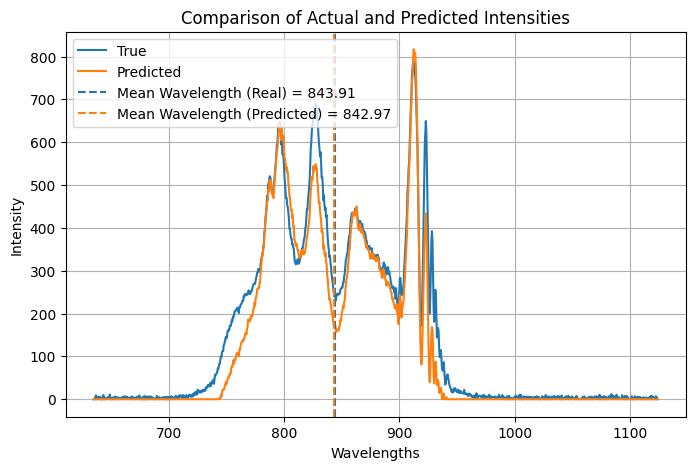

Found Optimal Parameters: [-1.31183042 -0.80926075 -3.21113878  0.1716     -1.2191     -1.
  0.         -2.6971     -3.295       0.4977     22.98       51.99
  0.24      ]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 2574.8358422376637
Mean Wavelength (Real): 843.91
Mean Wavelength (Predicted): 842.97


In [7]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", 
                         "L1-PL4-PZM67_Setpoint"]
spectrum_index = 1000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 1484
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL4-PZM67_Setpoint']
Optimized indices: [0, 2, 7]
Fixed indices: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12]
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [1.4315771381267943, -1.1627262425170788, 0.15312144775933323]
Real Parameters (Target): [ 0.1608 -0.3544 -2.0162]


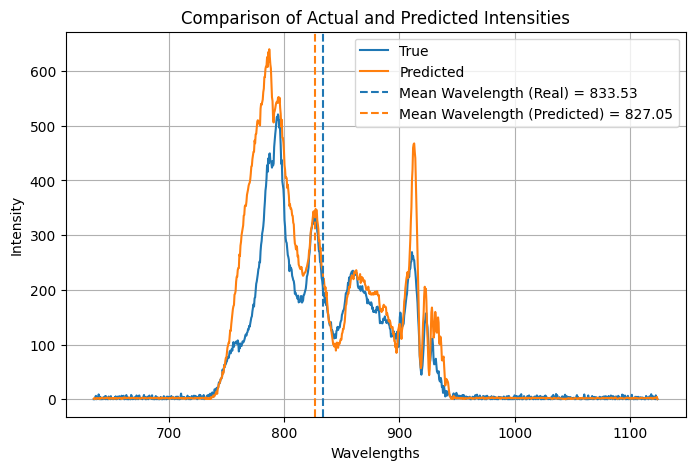

Found Optimal Parameters: [ 1.43157714 -1.16272624  0.15312145 -0.6987     -1.3708     -2.
 -1.         -0.8261     -2.1484      1.4647     18.05       23.03
  0.05      ]
Real Parameters: [ 0.1608 -0.6987 -0.3544 -1.3708 -2.     -1.     -0.8261 -2.0162 -2.1484
  1.4647 18.05   23.03    0.05  ]
Best Loss (MSE): 4506.978060367811
Mean Wavelength (Real): 833.53
Mean Wavelength (Predicted): 827.05


In [8]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", 
                         "L1-PL4-PZM67_Setpoint"]
spectrum_index = 1484

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 2000
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL4-PZM67_Setpoint']
Optimized indices: [0, 2, 7]
Fixed indices: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12]
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [-0.25309220883514705, -0.7977691969912042, -3.22718987512022]
Real Parameters (Target): [-0.2422 -0.0813 -1.0022]


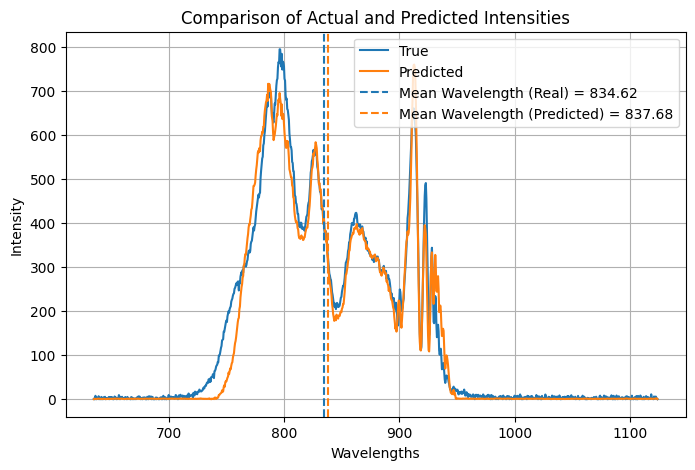

Found Optimal Parameters: [-0.25309221 -0.7977692  -3.22718988 -0.2185     -1.744      -1.
 -1.          1.7146      1.281       0.9939     39.08       43.71
  0.        ]
Real Parameters: [-0.2422 -0.2185 -0.0813 -1.744  -1.     -1.      1.7146 -1.0022  1.281
  0.9939 39.08   43.71    0.    ]
Best Loss (MSE): 1625.4546665257371
Mean Wavelength (Real): 834.62
Mean Wavelength (Predicted): 837.68


In [10]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", 
                         "L1-PL4-PZM67_Setpoint"]
spectrum_index = 2000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 1000
Optimizing parameters: ['L1-INJ-PM70:VAL_CAL', 'L1-OPA3-5_2-PM98:VAL_CAL', 'L1-INJ-PM70:VAL_CAL_diff']
Optimized indices: [10, 11, 12]
Fixed indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [26.988865897919908, 9.008319144787592, -11.987635058884742]
Real Parameters (Target): [22.98 51.99  0.24]


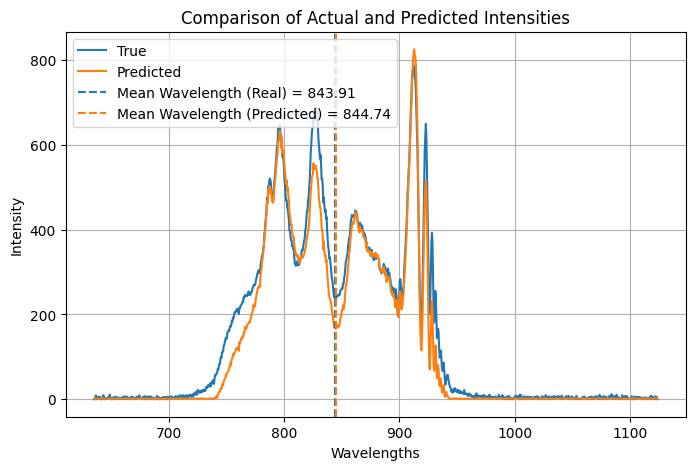

Found Optimal Parameters: [ 26.9888659    9.00831914 -11.98763506  -0.6233       0.1716
  -0.4695      -1.2191      -1.           0.          -2.6971
  -0.4462      -3.295        0.4977    ]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 1733.3506698606911
Mean Wavelength (Real): 843.91
Mean Wavelength (Predicted): 844.74


In [11]:
optimized_param_names = ["L1-INJ-PM70:VAL_CAL",
                        "L1-OPA3-5_2-PM98:VAL_CAL",
                        "L1-INJ-PM70:VAL_CAL_diff"]
spectrum_index = 1000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 1000
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM53_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL3-PZM57_Setpoint', 'L1-PL3-PZM58_Setpoint', 'L1-PL3-PZM59_Setpoint', 'L1-PL4-PZM66_Setpoint', 'L1-PL4-PZM67_Setpoint', 'L1-PL4-PZM68_Setpoint', 'L1-PL4-PZM69_Setpoint']
Optimized indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Fixed indices: [10, 11, 12]
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [-3.0, -3.0, -1.591, -0.01770000000000005, -3.0, -3.0, -3.75, 0.2801999999999998, 3.75, 3.75]
Real Parameters (Target): [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977]


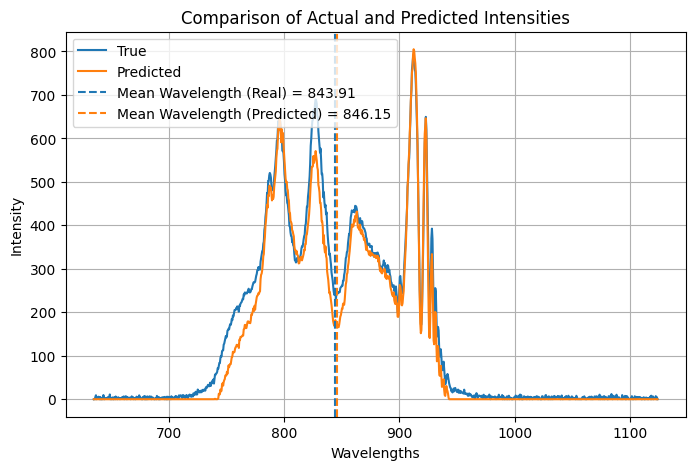

Found Optimal Parameters: [-3.000e+00 -3.000e+00 -1.591e+00 -1.770e-02 -3.000e+00 -3.000e+00
 -3.750e+00  2.802e-01  3.750e+00  3.750e+00  2.298e+01  5.199e+01
  2.400e-01]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 1330.1644156080267
Mean Wavelength (Real): 843.91
Mean Wavelength (Predicted): 846.15


In [12]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", "L1-PL3-PZM53_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", "L1-PL3-PZM57_Setpoint", 
                         "L1-PL3-PZM58_Setpoint", "L1-PL3-PZM59_Setpoint",
                         "L1-PL4-PZM66_Setpoint", "L1-PL4-PZM67_Setpoint", 
                         "L1-PL4-PZM68_Setpoint", "L1-PL4-PZM69_Setpoint"]
spectrum_index = 1000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 1000
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM53_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL3-PZM57_Setpoint', 'L1-PL3-PZM58_Setpoint', 'L1-PL3-PZM59_Setpoint', 'L1-PL4-PZM66_Setpoint', 'L1-PL4-PZM67_Setpoint', 'L1-PL4-PZM68_Setpoint', 'L1-PL4-PZM69_Setpoint', 'L1-INJ-PM70:VAL_CAL', 'L1-OPA3-5_2-PM98:VAL_CAL', 'L1-INJ-PM70:VAL_CAL_diff']
Optimized indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Fixed indices: []
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [-2.425674746370537, 2.623406518448564, -0.2602553544754087, -0.30865784753568093, -3.0, -0.48004833585532447, -0.34834088191535484, -2.1474768555132293, -3.75, 2.250972195693854, 3.548209215333279, 37.54249054673442, -13.042766117559456]
Real Parameters (Target): [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98

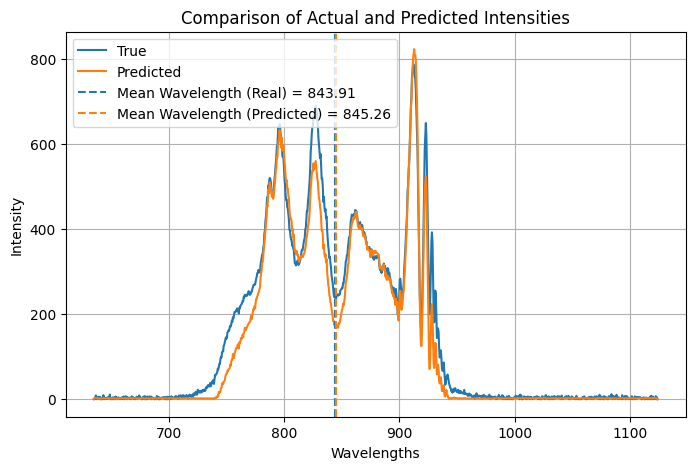

Found Optimal Parameters: [ -2.42567475   2.62340652  -0.26025535  -0.30865785  -3.
  -0.48004834  -0.34834088  -2.14747686  -3.75         2.2509722
   3.54820922  37.54249055 -13.04276612]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 1705.6947225997144
Mean Wavelength (Real): 843.91
Mean Wavelength (Predicted): 845.26


In [13]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", "L1-PL3-PZM53_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", "L1-PL3-PZM57_Setpoint", 
                         "L1-PL3-PZM58_Setpoint", "L1-PL3-PZM59_Setpoint",
                         "L1-PL4-PZM66_Setpoint", "L1-PL4-PZM67_Setpoint", 
                         "L1-PL4-PZM68_Setpoint", "L1-PL4-PZM69_Setpoint",
                        "L1-INJ-PM70:VAL_CAL",
                        "L1-OPA3-5_2-PM98:VAL_CAL",
                        "L1-INJ-PM70:VAL_CAL_diff"]
spectrum_index = 1000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )


Starting optimization for spectrum at index 1000
Optimizing parameters: ['L1-PL3-PZM52_Setpoint', 'L1-PL3-PZM53_Setpoint', 'L1-PL3-PZM56_Setpoint', 'L1-PL3-PZM57_Setpoint', 'L1-PL3-PZM58_Setpoint', 'L1-PL3-PZM59_Setpoint', 'L1-PL4-PZM66_Setpoint', 'L1-PL4-PZM67_Setpoint', 'L1-PL4-PZM68_Setpoint', 'L1-PL4-PZM69_Setpoint', 'L1-INJ-PM70:VAL_CAL', 'L1-OPA3-5_2-PM98:VAL_CAL', 'L1-INJ-PM70:VAL_CAL_diff']
Optimized indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Fixed indices: []
🚀 Running Bayesian optimization with 50 calls...

Optimization completed

📊 Plotting comparison of true vs predicted intensities...
Predicted Parameters (Optimized): [0.37263614935414635, 2.6501312733572497, -0.3898703260678571, -0.6627218496204748, 0.8602725873170867, -2.5663029192307807, 0.5475983513670961, -0.20179121218945717, 3.3426439479561667, 0.2633281805949377, 19.84981933814063, 24.011794760240047, -26.082814741932594]
Real Parameters (Target): [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -

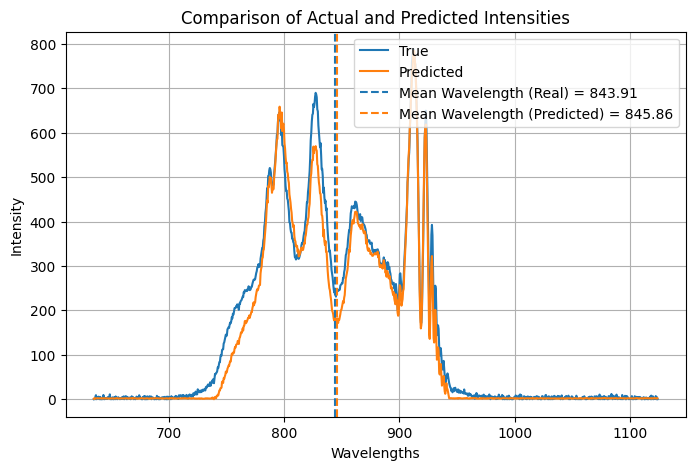

Found Optimal Parameters: [  0.37263615   2.65013127  -0.38987033  -0.66272185   0.86027259
  -2.56630292   0.54759835  -0.20179121   3.34264395   0.26332818
  19.84981934  24.01179476 -26.08281474]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 1241.4352588294773
Mean Wavelength (Real): 843.91
Mean Wavelength (Predicted): 845.86


In [14]:
optimized_param_names = ["L1-PL3-PZM52_Setpoint", "L1-PL3-PZM53_Setpoint", 
                         "L1-PL3-PZM56_Setpoint", "L1-PL3-PZM57_Setpoint", 
                         "L1-PL3-PZM58_Setpoint", "L1-PL3-PZM59_Setpoint",
                         "L1-PL4-PZM66_Setpoint", "L1-PL4-PZM67_Setpoint", 
                         "L1-PL4-PZM68_Setpoint", "L1-PL4-PZM69_Setpoint",
                        "L1-INJ-PM70:VAL_CAL",
                        "L1-OPA3-5_2-PM98:VAL_CAL",
                        "L1-INJ-PM70:VAL_CAL_diff"]
spectrum_index = 1000

best_params, best_loss = run_bayesian_optimization_for_spectrum(
                                            df=df,
                                            spectrum_index=spectrum_index,
                                            optimized_param_names=optimized_param_names,
                                            parameter_bounds=parameter_bounds,
                                            all_param_names=all_param_names,
                                            model=model,
                                            sampler=sampler,
                                            wavelengths=wavelengths,
                                            n_calls=50
                                            )